In [ ]:
!pip install spacy scikit-learn gensim pyLDAvis -q
!python -m spacy download en_core_web_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import spacy
import gensim
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import text
from collections import Counter

# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/SOSC314/CNN Dataset/CNN_Video_Cleaned.csv'
df = pd.read_csv(file_path)

df = df.dropna(subset=['transcript'])

In [ ]:
#preprocessing

# stopwords from scikit-learn
sklearn_stops = text.ENGLISH_STOP_WORDS
custom_stops = {
    'nbsp', 'uh', 'um', 'know', 'just', 'going', 'like', 'said',
    've', 'dont', 'get', 'say', 'yeah', 'could', 'actually',
    'would', 'also', 'really', 'much', 'well','thats'
}
all_stops = sklearn_stops.union(custom_stops)

#Use spaCy for cleaning and Lemmatization
def spacy_preprocess(text_data):
    doc = nlp(text_data.lower())
    # Filter out non-alphabetic characters, stop words and short words, and retain the original words
    tokens = [token.lemma_ for token in doc
              if token.is_alpha and not token.is_stop
              and token.lemma_ not in all_stops
              and len(token.lemma_) > 2]
    return " ".join(tokens)

df['clean_transcript'] = df['transcript'].apply(spacy_preprocess)


In [ ]:
# Tokenization and word frequency using CountVectorizer from scikit-learn

# ngram_range=(1, 2) automatically extracts single complex words and two-word phrases
vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(1, 2))
bow_matrix = vectorizer.fit_transform(df['clean_transcript'])

# Obtain the feature name and the total number of original word frequencies
feature_names = vectorizer.get_feature_names_out()
word_counts = np.asarray(bow_matrix.sum(axis=0)).flatten()
word_freq = dict(zip(feature_names, word_counts))

# Print the top 50 high-frequency words
top_50_words = Counter(word_freq).most_common(50)
print("Top 50 high-frequency words:")
for word, freq in top_50_words:
    print(f"{word}: {freq}")

Top 50 high-frequency words:
agent: 226
think: 222
enforcement: 199
officer: 196
law: 191
trump: 170
look: 161
video: 157
try: 148
immigration: 144
federal: 135
law enforcement: 130
arrest: 128
let: 122
president: 122
time: 121
vehicle: 119
day: 118
talk: 118
thing: 118
lot: 116
year: 116
way: 114
tell: 113
mean: 111
administration: 108
thank: 108
police: 107
family: 105
city: 104
hear: 104
new: 102
good: 100
community: 99
ask: 98
country: 97
question: 93
protest: 91
work: 89
car: 86
minneapolis: 83
point: 79
department: 77
criminal: 73
need: 73
official: 73
kind: 71
moment: 71
cnn: 70
state: 70


In [ ]:
# Recreate the DataFrame from top_50_words
df_top_words = pd.DataFrame(top_50_words, columns=['Word', 'Frequency'])

# Define the output file path in the same directory as the input file
# The original file path was '/content/drive/My Drive/SOSC314/CNN Dataset/CNN_Video_Cleaned.csv'
output_dir = os.path.dirname(file_path)
output_file_name = 'top_50_words.csv'
output_path = os.path.join(output_dir, output_file_name)

# Save the DataFrame to a CSV file
df_top_words.to_csv(output_path, index=False)

print(f"Top 50 words saved to: {output_path}")

Top 50 words saved to: /content/drive/My Drive/SOSC314/CNN Dataset/top_50_words.csv


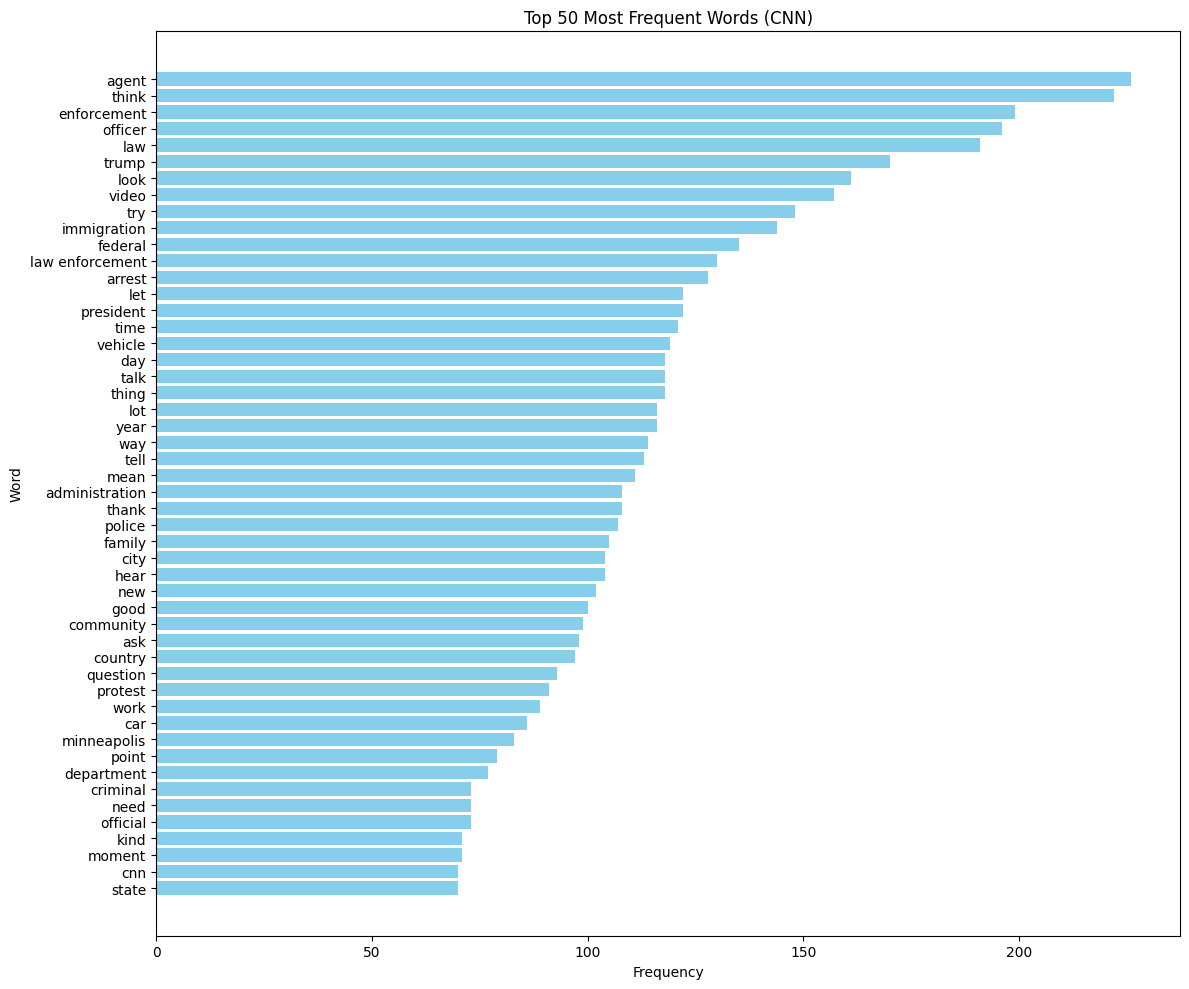

In [ ]:
#Visualization
import matplotlib.pyplot as plt

words = [word for word, freq in top_50_words]
frequencies = [freq for word, freq in top_50_words]

words.reverse()
frequencies.reverse()

plt.figure(figsize=(12, 10))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 50 Most Frequent Words (CNN)')
plt.tight_layout()
plt.show()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import gensim.corpora as corpora

# 1. Tokenize the clean_transcript column
# Each transcript is already a string of space-separated words, so splitting by space will tokenize it.
processed_docs = [doc.split() for doc in df['clean_transcript']]

# 3. Create a Gensim Dictionary from the processed_docs
dictionary = corpora.Dictionary(processed_docs)

# 4. Convert the processed_docs into a Bag-of-Words (BoW) corpus
corpus = [dictionary.doc2bow(text) for text in processed_docs]

print("Data preparation for LDA complete: processed_docs, dictionary, and corpus created.")

Data preparation for LDA complete: processed_docs, dictionary, and corpus created.


In [ ]:
import warnings
warnings.filterwarnings("ignore")
num_topics = 5
lda_model_bow = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=15,
    random_state=42
)

print("LDA topic modeling results")
for idx, topic in lda_model_bow.print_topics(-1):
    print(f"topic {idx}: {topic}")

LDA topic modeling results
topic 0: 0.013*"agent" + 0.012*"video" + 0.009*"right" + 0.009*"officer" + 0.009*"ice" + 0.008*"people" + 0.008*"come" + 0.008*"vehicle" + 0.008*"happen" + 0.007*"car"
topic 1: 0.015*"ice" + 0.009*"enforcement" + 0.009*"right" + 0.008*"officer" + 0.008*"law" + 0.007*"agent" + 0.007*"people" + 0.007*"try" + 0.006*"happen" + 0.006*"video"
topic 2: 0.014*"ice" + 0.012*"people" + 0.009*"think" + 0.008*"year" + 0.008*"immigration" + 0.007*"right" + 0.007*"family" + 0.006*"trump" + 0.006*"sort" + 0.006*"new"
topic 3: 0.018*"people" + 0.009*"trump" + 0.009*"president" + 0.009*"ice" + 0.008*"think" + 0.007*"agent" + 0.007*"right" + 0.006*"look" + 0.006*"administration" + 0.006*"immigration"
topic 4: 0.017*"people" + 0.010*"right" + 0.009*"think" + 0.009*"want" + 0.008*"protest" + 0.007*"come" + 0.007*"ice" + 0.006*"trump" + 0.006*"happen" + 0.006*"community"


In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model_bow, corpus, dictionary)

# In a Jupyter or Colab notebook, use pyLDAvis.display(vis) to show the visualization
pyLDAvis.display(vis)

In [ ]:
#pyLDAvis.save_html(vis, 'CNN_lda_visualization.html')

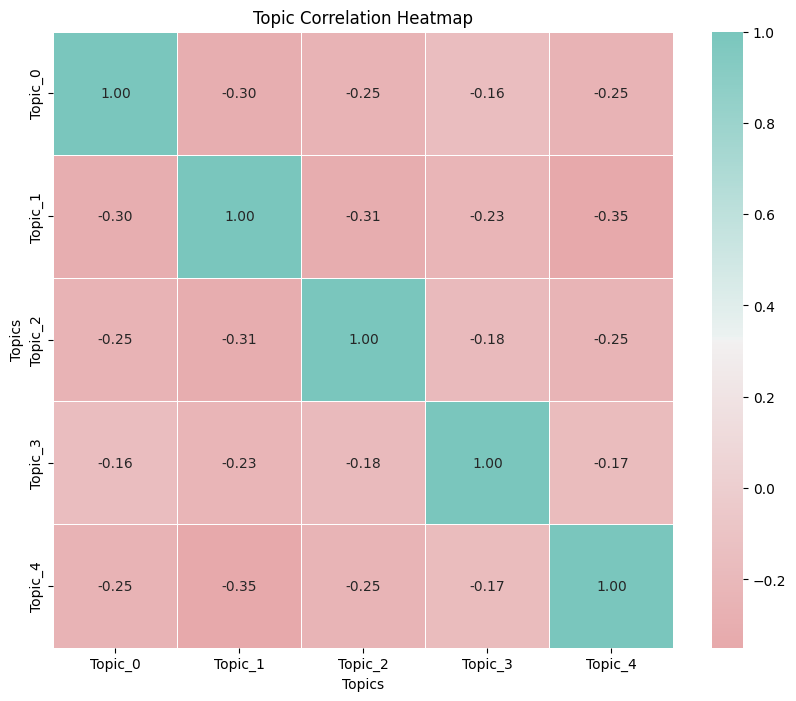

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get document-topic probabilities
# lda_model_bow[corpus] returns a list of lists of (topic_id, probability) tuples for each document
doc_topic_probs = []
for i, doc_topics in enumerate(lda_model_bow[corpus]):
    # For each document, create a list of probabilities for each topic
    # Initialize with zeros for all topics
    topic_prob_row = [0] * num_topics
    for topic_id, prob in doc_topics:
        topic_prob_row[topic_id] = prob
    doc_topic_probs.append(topic_prob_row)

# Convert to DataFrame
df_doc_topic = pd.DataFrame(doc_topic_probs, columns=[f'Topic_{i}' for i in range(num_topics)])

# Calculate topic correlation (Pearson correlation by default)
topic_correlation_matrix = df_doc_topic.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
# Use a custom diverging palette for lighter pink and turquoise
sns.heatmap(topic_correlation_matrix, annot=True, cmap=sns.diverging_palette(h_neg=10, h_pos=180, s=60, l=75, as_cmap=True), fmt=".2f", linewidths=.5, cbar=True)
plt.title('Topic Correlation Heatmap')
plt.xlabel('Topics')
plt.ylabel('Topics')
plt.show()